In [1]:
import torch 
import numpy as np 
import os 
from torch.utils.data import Dataset, DataLoader 
import glob 
import pandas as pd 
import albumentations as A
from PIL import Image

In [2]:
data_path = r'C:\Users\Amzad\Desktop\camvid-segmentation\dataset\DronData\dataset\semantic_drone_dataset'
original_images_path = os.path.join(data_path, 'original_images/')
label_images_path = os.path.join(data_path, 'label_images_semantic/')
label_images_path

'C:\\Users\\Amzad\\Desktop\\camvid-segmentation\\dataset\\DronData\\dataset\\semantic_drone_dataset\\label_images_semantic/'

In [3]:
# create a dataframe with id of the images without extensions (.jpg)
def create_df():
    name = []
    mask = []
    for dirname, _, filenames in os.walk(original_images_path): # given a directory iterates over the files
        for filename in filenames:
            f = filename.split('.')[0]
            name.append(f)

    return pd.DataFrame({'id': name}, index = np.arange(0, len(name))).sort_values('id').reset_index(drop=True)


df = create_df() 

X = create_df()['id'].values

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_val = train_test_split(X, test_size=0.25, random_state=123)
X_test, X_val = train_test_split(X_val, test_size=0.4, random_state=123) 

In [5]:
print('Train Size   : ', len(X_train))
print('Val Size     : ', len(X_val))
print('Test Size    : ', len(X_test))

Train Size   :  300
Val Size     :  40
Test Size    :  60


In [6]:
class DroneDataset(Dataset):
    
    def __init__(self, img_path, mask_path, X, transform=None):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        image = np.array(Image.open(self.img_path + self.X[idx] + '.jpg'))
        mask = np.array(Image.open(self.mask_path + self.X[idx] + '.png')) # relabel classes from 1,2 --> 0,1 where 0 is background
        
        # augment images
        if self.transform!=None:
            aug = self.transform(image=image, mask=mask)
            image = aug['image']
            mask = aug['mask']
        
        norm = A.Normalize()(image = image, mask = np.expand_dims(mask, 0))
        #covert mask to one hot encoding 
        mask_one_hot = np.zeros(( mask.shape[0], mask.shape[1],22),)
        for i, unique_value in enumerate(np.unique(mask)):
            mask_one_hot[:, :, i][mask == unique_value] = 1


        return norm['image'].transpose(2, 0, 1), mask_one_hot.transpose(2, 0, 1).astype('float32')
        
    
      

In [21]:
t = A.Compose([A.HorizontalFlip(p=0.5), A.VerticalFlip(p=0.5), A.GaussNoise(),
             A.GridDistortion(p=0.2), A.RandomBrightnessContrast((0,0.5),(0,0.5), p=0.4),A.Resize(512, 512)])


# t = A.Compose([A.Resize(512, 512)])
t2= A.Compose([A.Resize(512,512)])

# datasets
train_dataset = DroneDataset(original_images_path, label_images_path, X_train,t)
valid_dataset = DroneDataset(original_images_path, label_images_path, X_val,t)
test_dataset = DroneDataset(original_images_path, label_images_path, X_test)

# dataloader
batch_size = 8

train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_dl = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_dl = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


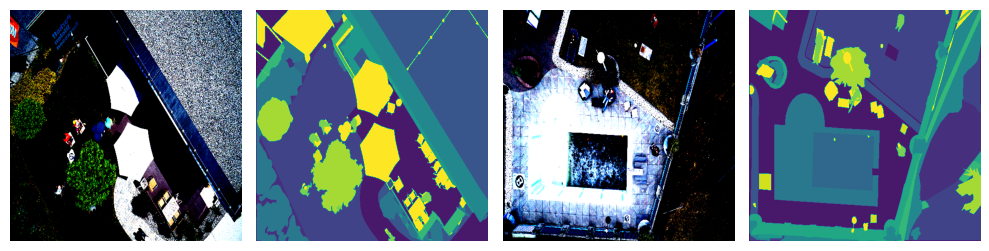

In [24]:
import matplotlib.pyplot as plt
#subplot images and corresponding masks 
data = train_dl.dataset[0] 
image = data[0].transpose(1, 2, 0)
mask = data[1].transpose(1, 2, 0)
data1 = train_dl.dataset[1] 
image1 = data1[0].transpose(1, 2, 0)
mask1 = data1[1].transpose(1, 2, 0)


fig, ax = plt.subplots(1, 4, figsize=(10, 50))
ax[0].imshow(image)
ax[1].imshow(np.argmax(mask, axis=2))
ax[0].axis('off')
ax[1].axis('off')
ax[2].imshow(image1)
ax[3].imshow(np.argmax(mask1, axis=2))
ax[2].axis('off')
ax[3].axis('off')

plt.tight_layout()
plt.show()


In [ ]:

import torch.nn.functional as F
def diceloss(inputs=None, targets=None, smooth=1):
    
    #comment out if your model contains a sigmoid or equivalent activation layer
    #inputs = F.sigmoid(inputs)       
    
    #flatten label and prediction tensors
    inputs = inputs.view(-1)
    targets = targets.view(-1)
    
    intersection = (inputs * targets).sum()                            
    dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
    
    return 1 - dice

In [ ]:
import segmentation_models_pytorch as smp
import segmentation_models_pytorch.utils.metrics as mtrcs
arch = 'unet'
enc_name = 'efficientnet-b0'
classes = 22

iou = mtrcs.IoU(threshold=0.5, ignore_channels=None) 
f1 = mtrcs.Fscore(threshold=0.5, beta=1, ignore_channels=None)

model = smp.create_model(arch,
                         encoder_name = enc_name,
                         encoder_weights = "imagenet",
                         in_channels = 3,
                         activation = 'softmax',
                         classes = classes).to("cuda")

optimizer = torch.optim.Adam(model.parameters(), lr=1e-03)
#criterion = smp.losses.FocalLoss("multiclass", alpha=0.5, gamma=2, ignore_channels=None, balance=None, reduction='mean')
criterion = torch.nn.CrossEntropyLoss()
#criterion = criterion(torch.from_numpy(y).to("cuda"), torch.from_numpy(y).to("cuda"))

In [ ]:
loss = smp.utils.losses.DiceLoss()

metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
    smp.utils.metrics.Fscore(threshold=0.5),
]

train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device="cuda",
    verbose="cuda",
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device="cuda",
    verbose=True,
)

In [ ]:
# train model for 40 epochs

max_score = 0
for i in range(0, 40):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_dl)
    valid_logs = valid_epoch.run(val_dl)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model.pth')
        print('Model saved!')
        
    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')

In [ ]:
for i in y 
    print(i.shape)

In [ ]:
import torch.nn as nn 

class SoftDiceLossV1(nn.Module):
    '''
    soft-dice loss, useful in binary segmentation
    '''
    def __init__(self,
                 p=1,
                 smooth=1):
        super(SoftDiceLossV1, self).__init__()
        self.p = p
        self.smooth = smooth

    def forward(self, logits, labels):
        '''
        inputs:
            logits: tensor of shape (N, H, W, ...)
            label: tensor of shape(N, H, W, ...)
        output:
            loss: tensor of shape(1, )
        '''
        probs = torch.sigmoid(logits)
        numer = (probs * labels).sum()
        denor = (probs.pow(self.p) + labels.pow(self.p)).sum()
        loss = 1. - (2 * numer + self.smooth) / (denor + self.smooth)
        return loss

In [ ]:

class IOU(nn.Module): 
    def __init__(self, n_classes=22):
        super().__init__()
        self.n_classes = n_classes 

    def forward(self, pred, target):
        #intersection between pred and target at dimention -1 
        intersection = np.logical_and(target, pred)
        #union between pred and target at dimention -1
        union = np.logical_or(target, pred)
        #sum of intersection and union
        iou_score = np.sum(intersection) / np.sum(union)
        return iou_score 
    
    def __str__(self): 
        return f"IOU(n_classes={self.n_classes})" 


In [ ]:
#import tqdm
from tqdm import tqdm
def train(model, train_dl, val_dl, optimizer, criterion, epochs=10):
    train_loss = []
    val_loss = []
    dice_score = []
    iou_score = []

    print("Training Started...")
    for epoch in tqdm(range(epochs)):
        print(f"Epoch {epoch+1} of {epochs}")
        model.train()
        running_loss = 0.0
        #use tqdm for progress bar 
        for x, y in train_dl: 
            x = x.to("cuda")
            y = y.to("cuda")
            optimizer.zero_grad()
            y_hat = model(x)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            #soft dice loss 
       
         
     



        epoch_loss = running_loss / len(train_dl)
        train_loss.append(epoch_loss)
        print(f"Train Loss: {epoch_loss:.4f}")
        
        model.eval()
        running_loss = 0.0
        for x, y in val_dl:
            x = x.to("cuda")
            y = y.to("cuda")
            with torch.no_grad():
                y_hat = model(x)
                iou_score.append(IOU()(y_hat.cpu().numpy(), y.cpu().numpy()))
                
                
                loss = criterion(y_hat, y)
                running_loss += loss.item()
        epoch_loss = running_loss / len(val_dl)
        val_loss.append(epoch_loss)
        print(f"Val Loss: {epoch_loss:.4f}")
        print(f"IoU Score: {np.mean(iou_score):.4f}")
   
        

    return train_loss, val_loss, dice_score, iou_score

In [ ]:
softd= SoftDiceLossV1()

train_loss, val_loss = train(model, train_dl, val_dl, optimizer, softd, epochs=10)

# save the model
torch.save(model.state_dict(), 'model_10-30-23.h5')


In [ ]:
def one_hot_to_rgb(one_hot_tensor):
    """
    Converts a one-hot encoded tensor to an rgb image
    """
    # First, convert to an rgb image with channels = classes
    single_channel = torch.argmax(one_hot_tensor, dim=1).squeeze(0)
    # Next, create an empty tensor to hold the new image
    rgb_tensor = torch.zeros((3, single_channel.shape[0], single_channel.shape[1]))
    # Now, loop through and create the new image
    for class_idx in range(len(class_dict)):
        mask = single_channel == class_idx
        rgb_tensor[0][mask] = torch.tensor(class_dict[class_idx][0])
        rgb_tensor[1][mask] = torch.tensor(class_dict[class_idx][1])
        rgb_tensor[2][mask] = torch.tensor(class_dict[class_idx][2])
    return rgb_tensor

In [ ]:
# plot the loss vs epochs
import matplotlib.pyplot as plt 
plt.plot(train_loss, label='train loss')
plt.plot(val_loss, label='val loss')
plt.xlabel('epochs')
plt.ylabel('loss') 
plt.legend()

In [ ]:
import segmentation_models_pytorch as smp
import segmentation_models_pytorch.utils.metrics as mtrcs

In [ ]:
arch = 'unet'
enc_name = 'efficientnet-b0'
classes = 22

iou = mtrcs.IoU(threshold=0.5, ignore_channels=None) 
f1 = mtrcs.Fscore(threshold=0.5, beta=1, ignore_channels=None)

model = smp.create_model(arch,
                         encoder_name = enc_name,
                         encoder_weights = "imagenet",
                         in_channels = 3,
                         activation = 'softmax',
                         classes = classes).to("cuda")
    

In [ ]:
model.load_state_dict(torch.load(r'C:\Users\Amzad\Desktop\camvid-segmentation\notebook\best_model.pth'))

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
#predict on valset 
for x, y in val_dl: 
    #model.eval()
    x = x.to("cuda")
    y = y.to("cuda")
    with torch.no_grad():
        y_hat = model(x)
        #subplot(1,2,1)
        plt.imshow(x[7].permute(1, 2, 0).cpu().numpy())
        plt.show()
        #subplot(1,2,2)
        plt.imshow(np.argmax(y_hat[7].cpu().numpy(), axis=0))
        plt.show()
        plt.imshow(np.argmax(y[7].cpu().numpy(), axis=0))
        plt.show()
        break


In [ ]:
single_image  = Image.open(r'C:\Users\Amzad\Desktop\camvid-segmentation\dataset\DronData\dataset\semantic_drone_dataset\label_images_semantic\001.png')
single_image = np.array(single_image)
print(single_image.shape)
print(np.unique(single_image))
one_hot=np.zeros((3,3,22))
for i, unique_value in enumerate(np.unique(single_image)):
    one_hot[:, :, i][single_image == unique_value] = 1
print(one_hot.shape)
